## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [161]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [162]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [163]:
import sqlite3

sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

#### Merge some Classes that are very similiar to each other

In [164]:
df_all[df_all["Instruction_id"] == 'coffee-ordering-1'] = 'coffee-ordering'
df_all[df_all["Instruction_id"] == 'coffee-ordering-2'] = 'coffee-ordering'
df_all[df_all["Instruction_id"] == 'pizza-ordering-1'] = 'pizza-ordering'
df_all[df_all["Instruction_id"] == 'pizza-ordering-2'] = 'pizza-ordering'
df_all[df_all["Instruction_id"] == 'restaurant-table-1'] = 'restaurant-table'
df_all[df_all["Instruction_id"] == 'restaurant-table-2'] = 'restaurant-table'
df_all[df_all["Instruction_id"] == 'uber-lyft-1'] = 'uber-lyft'
df_all[df_all["Instruction_id"] == 'uber-lyft-2'] = 'uber-lyft'
print (df_all.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    1161
coffee-ordering       1376
movie-finder            54
movie-tickets-1        679
movie-tickets-2        377
movie-tickets-3        195
pizza-ordering        1468
restaurant-table      1198
restaurant-table-3     102
uber-lyft             1098
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [165]:
df_all['category'] = df_all['Instruction_id'].factorize()[0]

In [166]:
df_all.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [167]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [168]:
for i, row in df_all.iterrows():
    df_all.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

df_all = df_all.filter(['Instruction_id', 'category', 'selfdialog_norm'], axis=1)

df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table,0,restauranttable
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


In [169]:
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

#### Remove NaN rows

In [170]:
print(df_all.shape)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
df_all = df_all[df_all.selfdialog_norm != '']
print(df_all.shape)

(7708, 3)
(7706, 3)


#### Save New Cleaned File

In [171]:
df_all.to_csv('./data/dialog_norm.csv', index=False)
#df_all.to_sql('dialog_norm', con, if_exists='replace')

#### Get a Sample of records.

In [172]:
# class_sample_size_dict = {
#     "auto-repair-appt-1": 191,
#     "coffee-ordering-1": 96,
#     "coffee-ordering-2": 97,
#     "movie-finder": 54,
#     "movie-tickets-1": 193,
#     "movie-tickets-2": 193,
#     "movie-tickets-3": 195,
#     "pizza-ordering-1": 96,
#     "pizza-ordering-2": 97,
#     "restaurant-table-1": 96,
#     "restaurant-table-2": 97,
#     "restaurant-table-3": 102,
#     "uber-lyft-1": 96,
#     "uber-lyft-2": 97
# }
# sum(class_sample_size_dict.values())
class_sample_size_dict = {
    "auto-repair-appt-1": 230,
    "coffee-ordering": 230,
    "movie-finder": 54,
    "movie-tickets-1": 250,
    "movie-tickets-2": 250,
    "movie-tickets-3": 195,
    "pizza-ordering": 230,
    "restaurant-table": 230,
    "restaurant-table-3": 101,
    "uber-lyft": 230
}
sum(class_sample_size_dict.values())

2000

In [173]:
# cat_id_df = df_all[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
# cat_count = len(cat_id_df)
# sample_size = 1000
# sample_per_cat = sample_size//cat_count
# print('sample_size: ', sample_size, 'sample_per_cat: ', sample_per_cat)

In [174]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group):
    name = group['Instruction_id'].iloc[0]
    k = class_sample_size_dict[name]
    return group.sample(k, random_state=5)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)
print (corpus_df.groupby('Instruction_id').size(), corpus_df.shape)

Instruction_id
auto-repair-appt-1    230
coffee-ordering       230
movie-finder           54
movie-tickets-1       250
movie-tickets-2       250
movie-tickets-3       195
pizza-ordering        230
restaurant-table      230
restaurant-table-3    101
uber-lyft             230
dtype: int64 (2000, 3)


In [175]:
# # Function to Get balanced Sample - Get a bit more than needed then down sample
# def sampling_k_elements(group, k=sample_per_cat + 20):
#     if len(group) < k:
#         return group
#     return group.sample(k, random_state=10)

# #Get balanced samples
# corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

# #Reduce to sample_size
# corpus_df = corpus_df.sample(n=sample_size, random_state=3)
# print (corpus_df.groupby('Instruction_id').size())

#### Generate Corpus List

In [176]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

2000


['hi im issue car help sure whats problem light came saying headlight ok want get fixed right away today would ideal already know want take yes intelligent auto solutions ok let pull website online scheduler see today ok im looks like two appointments open today could minutes im least minutes away ok time would pm tonight tell able fix spot call confirm makemodel car kia soul ok said parts done appointment thats great news please book yes booked online thanks give info yes text youll phone thank big help',
 'hi schedule appointment car okay auto repair shop would like check check intelligent auto solutions car bringing lexus im driving put name cell phone number yes put jeff green cell phone number seems problem car makes sound step brakes anything else would like check like oil change maintenance yes think im due oil change well got let check online see available check bring mins able make appointment bring car time pm great thanks initial cost brake checkup oil change okay accept cre

#### Build Vocabulary

In [177]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5614
Vocabulary Sample: [('tickets', 1), ('pm', 2), ('like', 3), ('would', 4), ('ok', 5), ('okay', 6), ('movie', 7), ('see', 8), ('yes', 9), ('want', 10)]


#### Build (context_words, target_word) pair generator

In [178]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [179]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['want', 'make', 'auto', 'repair'] -> Target (Y): appointment
Context (X): ['make', 'appointment', 'repair', 'shop'] -> Target (Y): auto
Context (X): ['appointment', 'auto', 'shop', 'called'] -> Target (Y): repair
Context (X): ['auto', 'repair', 'called', 'intelligent'] -> Target (Y): shop
Context (X): ['repair', 'shop', 'intelligent', 'auto'] -> Target (Y): called
Context (X): ['shop', 'called', 'auto', 'solutions'] -> Target (Y): intelligent
Context (X): ['called', 'intelligent', 'solutions', 'okay'] -> Target (Y): auto
Context (X): ['intelligent', 'auto', 'okay', 'search'] -> Target (Y): solutions
Context (X): ['auto', 'solutions', 'search', 'information'] -> Target (Y): okay
Context (X): ['solutions', 'okay', 'information', 'car'] -> Target (Y): search
Context (X): ['okay', 'search', 'car', 'audi'] -> Target (Y): information


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [180]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [182]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [183]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,tickets,pm,like,would,ok,okay,movie,see,yes,want,time,showing,need,thank,...,shish,kebab,mediterranean,ibook,clams,rooftop,roof,madera,meats,lucia,compromise,diners,flora,stephan,pyles
0,0,0,0,0,0,1,3,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,2,5,0,0,1,3,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,3,2,0,2,0,1,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,6,0,0,2,3,1,1,0,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,3,0,1,4,0,0,2,0,0,5,0,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [184]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(1500, 5614)
(500, 5614)
(500,)


#### Define Model Builder Function

In [185]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [186]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [187]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [188]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.9306527,0.9240000,0.9253405,0.9240000


In [189]:
from sklearn.metrics import confusion_matrix

rm_nb_bow.cm

array([[64,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 58,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 13,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 52, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9, 43, 12,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 37,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 63,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 56]], dtype=int64)

In [190]:
from sklearn import metrics

print("Label" + rm_nb_bow.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       1.00      1.00      1.00        58
      movie-finder       1.00      0.87      0.93        15
   movie-tickets-1       0.76      0.85      0.81        61
   movie-tickets-2       0.67      0.74      0.70        58
   movie-tickets-3       0.97      0.76      0.85        49
    pizza-ordering       1.00      1.00      1.00        56
  restaurant-table       1.00      1.00      1.00        63
restaurant-table-3       1.00      1.00      1.00        20
         uber-lyft       1.00      1.00      1.00        56

          accuracy                           0.92       500
         macro avg       0.94      0.92      0.93       500
      weighted avg       0.93      0.92      0.93       500



## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [191]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

# def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
#     x_train_scaled, x_test_scaled = Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler)
#     X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, x_train_scaled, labels_train, x_test_scaled, labels_test)
#     rm_chi = Build_Model(model, X_train_chi, labels_train, X_test_chi, labels_test)
#     return rm_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [192]:
def Get_ABC_Range(x, a, c):
    a = a
    tot = x.shape[1]
    b = 100 * (tot//100)
    c = c
    return a, b, c

In [193]:
rows = []
a, b, c = Get_ABC_Range(X_train_bow, 100, 100)
scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])  
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


5500/5600

#### Plot f1-score by number of selected features

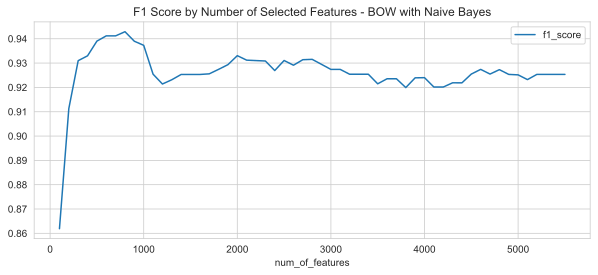

In [194]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [195]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

750 850 1


,num_of_features,f1_score,accuracy
7,800,0.9428929,0.9420000
6,700,0.9411912,0.9400000
5,600,0.9411912,0.9400000
4,500,0.9390292,0.9380000
8,900,0.9389734,0.9380000


#### Get a more fine-grained look at the optimal number of features region

In [196]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

849/850

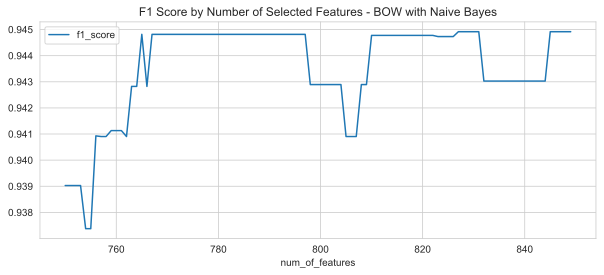

In [197]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [198]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

849


,num_of_features,f1_score,accuracy
99,849,0.9449159,0.9440000
77,827,0.9449159,0.9440000
81,831,0.9449159,0.9440000
79,829,0.9449159,0.9440000
78,828,0.9449159,0.9440000


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [199]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [200]:
print(rm_chi_opt_bow.cm)

[[64  0  0  0  0  0  0  0  0  0]
 [ 0 58  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0]
 [ 0  0  1 53 11  2  0  0  0  0]
 [ 0  0  0  8 47  6  0  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0]
 [ 0  0  0  0  0  0 56  0  0  0]
 [ 0  0  0  0  0  0  0 63  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 56]]


In [201]:
print("Label" + rm_chi_opt_bow.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       1.00      1.00      1.00        58
      movie-finder       1.00      0.93      0.97        15
   movie-tickets-1       0.79      0.87      0.83        61
   movie-tickets-2       0.77      0.81      0.79        58
   movie-tickets-3       1.00      0.84      0.91        49
    pizza-ordering       1.00      1.00      1.00        56
  restaurant-table       1.00      1.00      1.00        63
restaurant-table-3       1.00      1.00      1.00        20
         uber-lyft       1.00      1.00      1.00        56

          accuracy                           0.94       500
         macro avg       0.96      0.94      0.95       500
      weighted avg       0.95      0.94      0.94       500



In [202]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.9306527,0.9240000,0.9253405,0.9240000
1,BOW Naive Bayes Optimal Features Selected: 849,BOW,0.9478845,0.9440000,0.9449159,0.9440000


In [203]:
df_bow_train = pd.DataFrame(rm_chi_opt_bow.x_train_sel)
df_bow_train.to_csv('./data/bow_selected_train.csv', index=False)

df_bow_test = pd.DataFrame(rm_chi_opt_bow.x_test_sel)
df_bow_test.to_csv('./data/bow_selected_train.csv', index=False)

## Bag of N-Grams Feature Extraction

In [204]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(X_train)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [205]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,aamir khan,ability scan,able attend,able book,able bring,able complete,able confirm,able contact,able drive,able drop,able get,able help,able look,able make,able meet,...,yup ok,yup pick,yup thats,yup times,yup using,yupno sorry,zelos april,zelos info,zelos owner,zip code,zipcode dallas,zipcode thanks,zipcode theatre,zipcode theatres,zone seen
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [206]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(1500, 36598)
(500, 36598)
(500,)


## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [207]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
results_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [208]:
# Save benchmark output
Save_Benchmark("Bag of N-Gram Naive Bayes baseline", "BONG", results_nb_bong, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Bag of N-Gram Naive Bayes baseline,BONG,0.3878078,0.4260000,0.3815457,0.4260000


In [209]:
from sklearn.metrics import confusion_matrix

results_nb_bong.cm

array([[64,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 46, 10,  1,  0,  0,  0,  0],
       [ 0, 58,  2, 15, 43, 15, 56, 63,  1, 56],
       [ 0,  0,  2,  0,  5, 33,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [210]:
from sklearn import metrics

print(results_nb_bong.report)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       0.00      0.00      0.00        58
      movie-finder       1.00      0.73      0.85        15
   movie-tickets-1       0.81      0.75      0.78        61
   movie-tickets-2       0.14      0.74      0.23        58
   movie-tickets-3       0.77      0.67      0.72        49
    pizza-ordering       0.00      0.00      0.00        56
  restaurant-table       0.00      0.00      0.00        63
restaurant-table-3       1.00      0.80      0.89        20
         uber-lyft       0.00      0.00      0.00        56

          accuracy                           0.43       500
         macro avg       0.47      0.47      0.45       500
      weighted avg       0.39      0.43      0.38       500



## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [211]:
rows = []
a = 200
b = 5700
c = 100
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    results_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

5600/5700

#### Plot f1-score by number of selected features

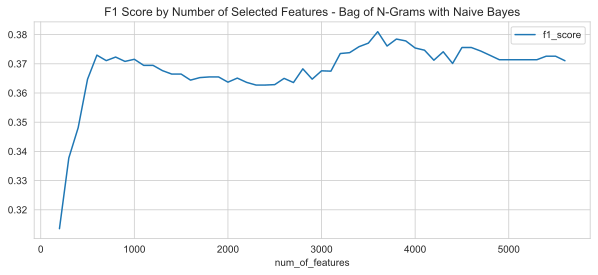

In [212]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [213]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

3550 3650 1


,num_of_features,f1_score,accuracy
34,3600,0.3809979,0.4300000
36,3800,0.3784832,0.4260000
37,3900,0.3778397,0.4260000
33,3500,0.3770803,0.4260000
35,3700,0.3760917,0.4220000


#### Get a more fine-grained look at the optimal number of features region

In [214]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

3649/3650

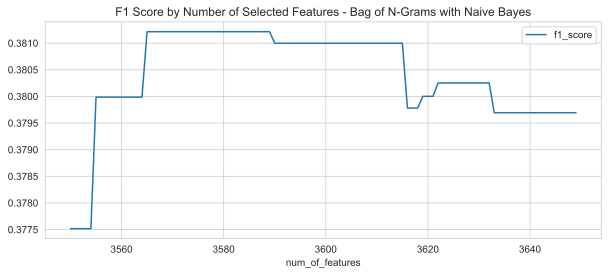

In [215]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [216]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
22,3572,0.3812146,0.4300000
15,3565,0.3812146,0.4300000
27,3577,0.3812146,0.4300000
26,3576,0.3812146,0.4300000
25,3575,0.3812146,0.4300000


## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [217]:
model_nb_bong_opt = MultinomialNB()
results_bong_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)

In [218]:
print(results_bong_opt.report)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.98      0.99        64
   coffee-ordering       0.00      0.00      0.00        58
      movie-finder       1.00      0.87      0.93        15
   movie-tickets-1       0.66      0.82      0.73        61
   movie-tickets-2       0.14      0.69      0.23        58
   movie-tickets-3       0.91      0.63      0.75        49
    pizza-ordering       0.00      0.00      0.00        56
  restaurant-table       0.00      0.00      0.00        63
restaurant-table-3       1.00      0.90      0.95        20
         uber-lyft       0.00      0.00      0.00        56

          accuracy                           0.43       500
         macro avg       0.47      0.49      0.46       500
      weighted avg       0.38      0.43      0.38       500



In [219]:
# Save benchmark output
Save_Benchmark("Bag of N-Gram Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BONG", results_bong_opt, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Bag of N-Gram Naive Bayes baseline,BONG,0.3878078,0.4260000,0.3815457,0.4260000
1,Bag of N-Gram Naive Bayes Optimal Features Selected: 3572,BONG,0.3832918,0.4300000,0.3812146,0.4300000


## TF-IDF Feature Extraction

In [220]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1500, 4803)
(500, 4803)


In [221]:
vocab_tfidf = count_vect.get_feature_names()
pd.DataFrame(X_train_tfidf.toarray(), columns=vocab_tfidf)

,aamir,ability,able,abnormal,aboutpm,aboutthe,abraham,abrams,abruptly,absolutely,ac,accel,accelerate,acceleration,accept,...,youll,younger,youplease,youre,youthat,youtube,youve,yum,yummier,yup,yupno,zelos,zip,zipcode,zone
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
3,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.1071726,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
4,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1496,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1497,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1498,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [222]:
clf = MultinomialNB()
results_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [223]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 4803)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [224]:
from sklearn.metrics import confusion_matrix

results_nb_tfidf.cm

array([[64,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 58,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4, 46, 12,  1,  0,  0,  0,  0],
       [ 0,  0, 11, 15, 46, 36,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0, 12,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 63,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 56]], dtype=int64)

In [225]:
from sklearn import metrics

print("Label" + results_nb_tfidf.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       1.00      1.00      1.00        58
      movie-finder       0.00      0.00      0.00        15
   movie-tickets-1       0.73      0.75      0.74        61
   movie-tickets-2       0.39      0.79      0.52        58
   movie-tickets-3       0.80      0.24      0.38        49
    pizza-ordering       1.00      1.00      1.00        56
  restaurant-table       1.00      1.00      1.00        63
restaurant-table-3       1.00      0.35      0.52        20
         uber-lyft       1.00      1.00      1.00        56

          accuracy                           0.82       500
         macro avg       0.79      0.71      0.72       500
      weighted avg       0.85      0.82      0.80       500



In [226]:
# Save benchmark output
Save_Benchmark("TF-IDF Naive Bayes Baseline", "TF-IDF", results_nb_tfidf, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,TF-IDF Naive Bayes Baseline,TF-IDF,0.8466997,0.8160000,0.8026432,0.8160000


## Feature Selection - TF-IDF with Naive Bayes

In [227]:
rows = []
scaler_max_abs = MaxAbsScaler()
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

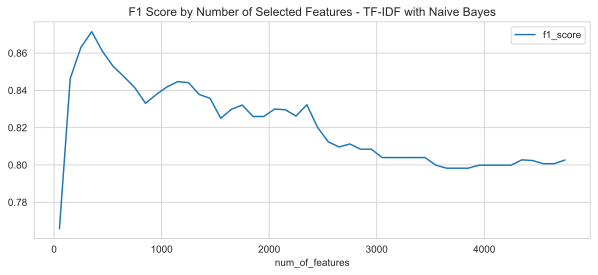

In [228]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [229]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

300 400 1


,num_of_features,f1_score,accuracy
3,350,0.8714680,0.8760000
2,250,0.8631261,0.8680000
4,450,0.8609195,0.8660000
5,550,0.8528173,0.8600000
6,650,0.8473325,0.8560000


#### Take closer look at region around optimal features

In [230]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

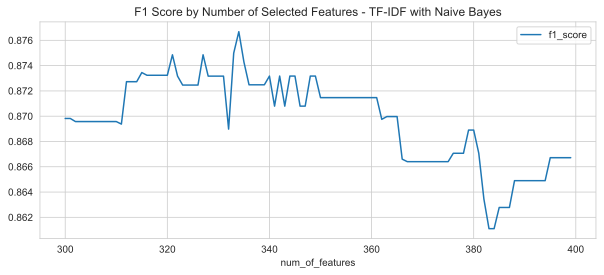

In [231]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [232]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
34,334,0.8766820,0.8820000
33,333,0.8749886,0.8800000
27,327,0.8748546,0.8800000
21,321,0.8748546,0.8800000
35,335,0.8742844,0.8800000


## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [233]:
results_tf_nb_opt = SelectBestModelFeatures_Chi(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
# Save benchmark output
Save_Benchmark("TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "TF-IDF", results_tf_nb_opt, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,TF-IDF Naive Bayes Baseline,TF-IDF,0.8466997,0.8160000,0.8026432,0.8160000
1,TF-IDF Naive Bayes Optimal Features Selected: 334,TF-IDF,0.9008577,0.8820000,0.8766820,0.8820000


#### Metrics For Each Class

In [234]:
from sklearn import metrics
print("Label" + results_tf_nb_opt.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       1.00      1.00      1.00        58
      movie-finder       1.00      0.27      0.42        15
   movie-tickets-1       0.75      0.84      0.79        61
   movie-tickets-2       0.56      0.83      0.67        58
   movie-tickets-3       0.81      0.45      0.58        49
    pizza-ordering       1.00      1.00      1.00        56
  restaurant-table       1.00      1.00      1.00        63
restaurant-table-3       1.00      0.95      0.97        20
         uber-lyft       1.00      1.00      1.00        56

          accuracy                           0.88       500
         macro avg       0.91      0.83      0.84       500
      weighted avg       0.90      0.88      0.88       500



## Word2Vec Feature Extraction

In [235]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

KeyError: "word 'terminator' not in vocabulary"

#### Visualizing word embeddings

In [236]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

KeyError: "word 'terminator' not in vocabulary"

#### Applying the word2vec model on our Train dataset

In [237]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [238]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [239]:
w2v_model.wv['jedi']

array([ 0.65259826, -0.28426412,  0.8320201 , -1.0614626 ,  0.14469506,
        0.87939864, -0.8767657 , -1.9990847 ,  1.1432    ,  0.51504505,
        0.32722592, -1.3524717 ,  0.36533725, -0.6041375 , -0.13285193,
        0.0592024 , -0.4039678 ,  0.45950317,  0.7545033 ,  0.33285025,
        1.1987023 ,  0.48661494,  0.63449687,  0.34816036,  1.8108022 ,
       -1.1850635 , -0.4495872 ,  0.33575678,  0.00257631, -0.24664077,
       -0.4453493 ,  1.3879058 ,  0.5560132 ,  0.06794152,  0.65652287,
       -0.4503078 , -0.11717761,  0.4045799 ,  0.22191134,  0.47181162,
        0.05722927, -0.058006  , -0.45762828,  0.6224233 ,  0.87882096,
        0.34888145, -0.02070761, -0.05201609,  0.4595562 , -0.462937  ,
        1.7131063 ,  0.15902515,  0.07277267,  0.4811689 ,  0.1963684 ,
       -0.36295605, -0.37809938,  1.3662219 , -0.17836548,  0.9429882 ,
        0.05883143,  0.8613169 ,  0.89527   , -0.49238813,  0.31584644,
        0.3103217 ,  0.02033386, -0.08788751,  0.9224042 , -0.65

#### Build framework for getting document level embeddings

In [240]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [241]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.0027392,0.0835557,-0.4999213,-1.0152732,0.0165822,-1.5406584,-0.1409362,-0.3702541,0.5755687,-0.8944055,-0.1953227,-2.0746095,-0.2587748,-0.7592781,-0.3576519,...,-0.5633285,-0.1496580,-0.0293249,1.4343310,-0.6229973,0.2675833,-0.1476144,-0.4442501,0.6353610,0.5992188,0.0650176,0.7086778,0.1335262,1.9535555,0.3329354
1,0.9378283,-0.3251491,-0.1872233,-0.2294881,-0.7165279,-1.2082069,0.1989546,-0.3922854,0.2865388,-0.5554327,0.3089839,-0.8949217,-0.6847160,-0.4824585,-0.2470042,...,-0.7130116,-0.2120205,-0.5965266,0.6525784,0.2806006,-0.1706689,0.1974184,-0.4336031,0.4212116,0.6234586,-0.1516776,0.5035531,-0.1041759,1.1275480,0.1308790
2,0.0019294,-0.0003710,0.0005646,-0.0027034,-0.0022093,-0.0000383,0.0007631,-0.0013805,0.0008299,-0.0047593,-0.0012237,-0.0000857,0.0041112,-0.0026628,-0.0001058,...,-0.0027542,-0.0008524,-0.0048590,-0.0000238,-0.0016578,0.0019622,0.0044852,-0.0047795,0.0045157,-0.0035917,-0.0002698,0.0039821,-0.0017352,-0.0041114,0.0029527
3,0.5495196,-0.1482777,0.2907130,0.6333234,-0.1596605,-0.4509763,-0.3175150,-0.1772763,-0.0688467,-0.3419145,-0.6335961,-0.9827451,-0.5093730,-0.8298235,-0.4689015,...,-0.0705424,0.2573828,-0.2966075,0.4811564,-0.2167089,-0.1704517,0.3017151,-0.6020218,0.1730001,0.1724767,-0.4117783,0.7957801,-0.7014334,0.3402256,-0.2338679
4,0.3960454,0.1044105,0.3466801,0.1406253,-0.4672486,-0.4062135,-0.4486866,0.1065927,0.5706972,-1.3197048,-0.6108754,-0.6694247,-0.6236715,-0.9947419,-0.2032359,...,-0.1591586,-0.4418931,-0.1193243,0.2621552,-0.4726640,-0.6689088,-0.0003324,-1.4440249,-0.0706403,1.1009306,-0.6530077,0.5170040,0.0371244,0.7037698,-0.2627166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.9079936,-0.1620472,-0.1700470,-0.1103658,-0.4091973,-1.4963362,-0.5691821,-0.3467755,0.1779748,-0.7699453,0.2324315,-1.3219979,-0.6745769,-0.6699721,-0.8108648,...,0.0729931,0.3134859,-0.1128586,0.7712164,-0.0357564,-0.3457440,-0.2129896,-0.7230091,0.5308122,0.2413752,-0.4265540,1.2712344,-1.0703510,0.7455945,-0.6629445
1496,0.0046476,-0.0044378,0.0016023,-0.0021833,-0.0023391,0.0029515,-0.0031971,0.0009764,0.0041819,0.0024201,0.0034152,0.0030533,0.0000211,0.0027367,-0.0031520,...,0.0014238,-0.0012910,0.0047561,0.0029321,-0.0045026,0.0031153,0.0015775,0.0030791,-0.0030625,0.0045550,0.0021572,0.0008471,-0.0034443,-0.0012780,-0.0034313
1497,0.0019294,-0.0003710,0.0005646,-0.0027034,-0.0022093,-0.0000383,0.0007631,-0.0013805,0.0008299,-0.0047593,-0.0012237,-0.0000857,0.0041112,-0.0026628,-0.0001058,...,-0.0027542,-0.0008524,-0.0048590,-0.0000238,-0.0016578,0.0019622,0.0044852,-0.0047795,0.0045157,-0.0035917,-0.0002698,0.0039821,-0.0017352,-0.0041114,0.0029527
1498,0.7404476,-0.3115035,0.0539258,0.5278451,-0.7493955,-0.8548491,-0.3471394,-0.4216888,0.4870532,-0.6114951,-0.5024797,-1.0857179,0.0219265,-0.6893886,-0.1286906,...,-0.1058406,-0.1665188,-0.0765566,-0.0064058,-0.3019695,-0.0663675,0.1084155,-1.0613286,-0.1176134,0.3519583,-0.1248302,0.5425662,-0.3276372,0.0908066,-0.2159026


In [242]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(500, 100)


## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [243]:
from sklearn.naive_bayes import GaussianNB

scaler_min_max = MinMaxScaler()
#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
results_nb_w2v = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Naive Bayes Baseline", "Word2Vec", results_nb_w2v, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Naive Bayes Baseline,Word2Vec,0.9134222,0.9080000,0.9095227,0.9080000


In [244]:
results_nb_w2v.cm

array([[64,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 58,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 42, 10,  2,  0,  0,  0,  0],
       [ 0,  0,  1, 19, 42,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6, 39,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 63,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 56]], dtype=int64)

In [245]:
print("Label" + results_nb_w2v.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       1.00      1.00      1.00        58
      movie-finder       1.00      0.93      0.97        15
   movie-tickets-1       0.78      0.69      0.73        61
   movie-tickets-2       0.60      0.72      0.66        58
   movie-tickets-3       0.87      0.80      0.83        49
    pizza-ordering       1.00      1.00      1.00        56
  restaurant-table       1.00      1.00      1.00        63
restaurant-table-3       1.00      1.00      1.00        20
         uber-lyft       1.00      1.00      1.00        56

          accuracy                           0.91       500
         macro avg       0.92      0.91      0.92       500
      weighted avg       0.91      0.91      0.91       500



## Feature Selection - Word2Vec Features with Naive Bayes Model

In [246]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

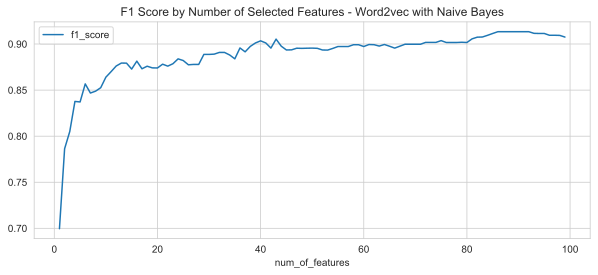

In [247]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [248]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
87,88,0.9133787,0.9120000
91,92,0.9133787,0.9120000
90,91,0.9133787,0.9120000
89,90,0.9133787,0.9120000
88,89,0.9133787,0.9120000


In [249]:
results_nb_w2v = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "Word2Vec", results_nb_w2v, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Naive Bayes Baseline,Word2Vec,0.9134222,0.9080000,0.9095227,0.9080000
1,Word2Vec Naive Bayes Optimal Features Selected: 88,Word2Vec,0.9164375,0.9120000,0.9133787,0.9120000


## Word2vec features Extraction with Fastext Model

In [250]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [251]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['rent', 'release', 'warranty', 'baby', 'diagnose'],
 'pizza': ['pizzaordering', 'wallet', 'drinks', 'food', 'jacksonville'],
 'terminator': ['nevermind', 'pm', 'cemetery', 'sorry', 'cemetary'],
 'star': ['wars', 'born', 'recommendations', 'rating', 'pa'],
 'audi': ['motor', 'manual', 'scheduled', 'transmission', 'leaking'],
 'east': ['river', 'suppose', 'chicago', 'usa', 'illinois'],
 'korean': ['mean', 'steering', 'keeps', 'little', 'inspection'],
 'playing': ['showing', 'theater', 'movie', 'tickets', 'theaters']}

#### PCA on Fasttext Model

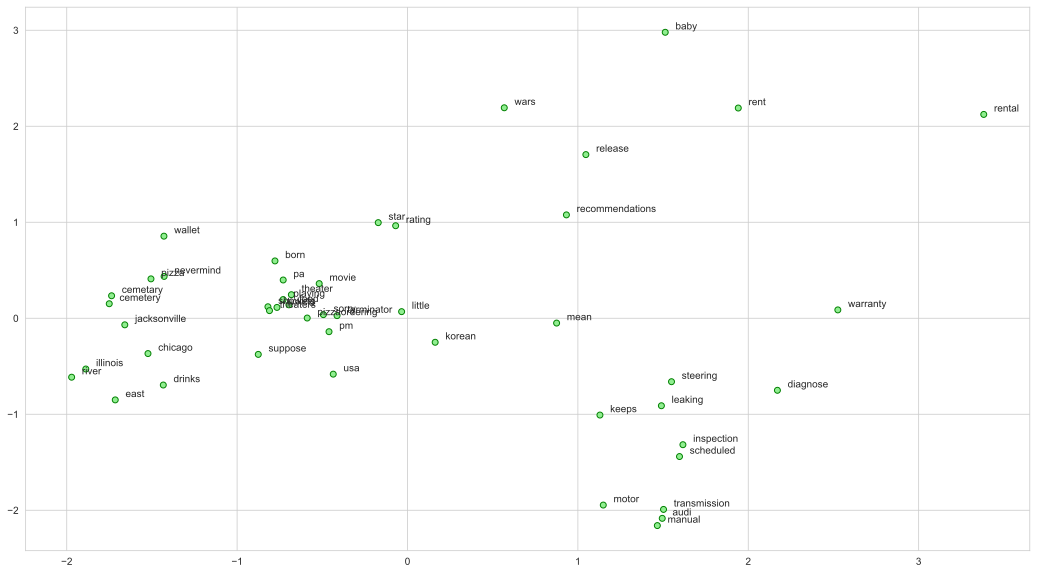

In [252]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [253]:
print(P.shape)

(48, 2)


In [254]:
ft_model.wv['rental']

array([ 0.36435804, -0.23089437,  0.30654365,  0.31551883, -0.18839094,
       -0.5751796 , -0.01248442, -0.3075056 ,  0.85285366, -0.6431286 ,
        0.9500618 ,  1.232377  , -0.63674814,  0.1510654 ,  0.3355674 ,
        0.36485967,  0.68574494,  0.16939339, -0.5984113 ,  1.0471454 ,
       -0.83975613,  0.29725298, -0.6417014 ,  0.08282176, -0.08857282,
       -0.7063474 , -0.8169301 ,  0.18439901, -1.403492  , -0.45826516,
       -0.05689065, -0.68029094, -0.7547481 ,  0.01525091,  0.37460962,
       -0.6259352 , -0.719684  , -1.2278401 , -0.69005525,  0.530808  ,
        0.01652725,  0.9154641 , -0.12055687, -0.887384  , -0.44385886,
       -0.48061988, -0.10294711, -0.68910426,  0.65742135, -0.13633469,
       -1.0232047 , -0.51197416, -0.4815853 ,  0.7231069 , -0.30123115,
        0.1875484 ,  0.35597572,  0.7254364 ,  0.07329717, -0.4449276 ,
        1.1140757 , -0.73386645,  0.92066383, -0.3309842 , -0.6718474 ,
       -0.10243788, -0.04274667,  0.74684495, -0.04142234, -0.35

In [255]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.24762978
0.718065


In [256]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pepperoni


## Word2Vec Features from Fastext Benchmarking with Naive Bayes Model

In [257]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.0027392,0.0835557,-0.4999213,-1.0152732,0.0165822,-1.5406584,-0.1409362,-0.3702541,0.5755687,-0.8944055,-0.1953227,-2.0746095,-0.2587748,-0.7592781,-0.3576519,...,-0.5633285,-0.1496580,-0.0293249,1.4343310,-0.6229973,0.2675833,-0.1476144,-0.4442501,0.6353610,0.5992188,0.0650176,0.7086778,0.1335262,1.9535555,0.3329354
1,0.9378283,-0.3251491,-0.1872233,-0.2294881,-0.7165279,-1.2082069,0.1989546,-0.3922854,0.2865388,-0.5554327,0.3089839,-0.8949217,-0.6847160,-0.4824585,-0.2470042,...,-0.7130116,-0.2120205,-0.5965266,0.6525784,0.2806006,-0.1706689,0.1974184,-0.4336031,0.4212116,0.6234586,-0.1516776,0.5035531,-0.1041759,1.1275480,0.1308790
2,0.0019294,-0.0003710,0.0005646,-0.0027034,-0.0022093,-0.0000383,0.0007631,-0.0013805,0.0008299,-0.0047593,-0.0012237,-0.0000857,0.0041112,-0.0026628,-0.0001058,...,-0.0027542,-0.0008524,-0.0048590,-0.0000238,-0.0016578,0.0019622,0.0044852,-0.0047795,0.0045157,-0.0035917,-0.0002698,0.0039821,-0.0017352,-0.0041114,0.0029527
3,0.5495196,-0.1482777,0.2907130,0.6333234,-0.1596605,-0.4509763,-0.3175150,-0.1772763,-0.0688467,-0.3419145,-0.6335961,-0.9827451,-0.5093730,-0.8298235,-0.4689015,...,-0.0705424,0.2573828,-0.2966075,0.4811564,-0.2167089,-0.1704517,0.3017151,-0.6020218,0.1730001,0.1724767,-0.4117783,0.7957801,-0.7014334,0.3402256,-0.2338679
4,0.3960454,0.1044105,0.3466801,0.1406253,-0.4672486,-0.4062135,-0.4486866,0.1065927,0.5706972,-1.3197048,-0.6108754,-0.6694247,-0.6236715,-0.9947419,-0.2032359,...,-0.1591586,-0.4418931,-0.1193243,0.2621552,-0.4726640,-0.6689088,-0.0003324,-1.4440249,-0.0706403,1.1009306,-0.6530077,0.5170040,0.0371244,0.7037698,-0.2627166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.9079936,-0.1620472,-0.1700470,-0.1103658,-0.4091973,-1.4963362,-0.5691821,-0.3467755,0.1779748,-0.7699453,0.2324315,-1.3219979,-0.6745769,-0.6699721,-0.8108648,...,0.0729931,0.3134859,-0.1128586,0.7712164,-0.0357564,-0.3457440,-0.2129896,-0.7230091,0.5308122,0.2413752,-0.4265540,1.2712344,-1.0703510,0.7455945,-0.6629445
1496,0.0046476,-0.0044378,0.0016023,-0.0021833,-0.0023391,0.0029515,-0.0031971,0.0009764,0.0041819,0.0024201,0.0034152,0.0030533,0.0000211,0.0027367,-0.0031520,...,0.0014238,-0.0012910,0.0047561,0.0029321,-0.0045026,0.0031153,0.0015775,0.0030791,-0.0030625,0.0045550,0.0021572,0.0008471,-0.0034443,-0.0012780,-0.0034313
1497,0.0019294,-0.0003710,0.0005646,-0.0027034,-0.0022093,-0.0000383,0.0007631,-0.0013805,0.0008299,-0.0047593,-0.0012237,-0.0000857,0.0041112,-0.0026628,-0.0001058,...,-0.0027542,-0.0008524,-0.0048590,-0.0000238,-0.0016578,0.0019622,0.0044852,-0.0047795,0.0045157,-0.0035917,-0.0002698,0.0039821,-0.0017352,-0.0041114,0.0029527
1498,0.7404476,-0.3115035,0.0539258,0.5278451,-0.7493955,-0.8548491,-0.3471394,-0.4216888,0.4870532,-0.6114951,-0.5024797,-1.0857179,0.0219265,-0.6893886,-0.1286906,...,-0.1058406,-0.1665188,-0.0765566,-0.0064058,-0.3019695,-0.0663675,0.1084155,-1.0613286,-0.1176134,0.3519583,-0.1248302,0.5425662,-0.3276372,0.0908066,-0.2159026


In [258]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [259]:
model_ft_nb = GaussianNB()
results_nb_ft = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Fastext Naive Bayes Baseline", "Word2Vec_FT", results_nb_ft, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Fastext Naive Bayes Baseline,Word2Vec_FT,0.8796808,0.8680000,0.8661048,0.8680000


## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [260]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

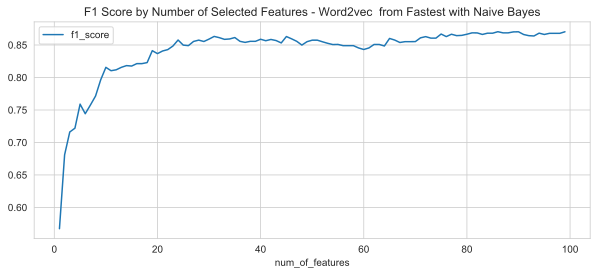

In [261]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [262]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
85,86,0.8704664,0.8720000
98,99,0.8703250,0.8720000
89,90,0.8703250,0.8720000
88,89,0.8701624,0.8720000
80,81,0.8687006,0.8700000


## Benchmarking Word2Vec Fastext with Naive Bayes on Optimal number of Features

In [263]:
results_nb_ft = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "Word2Vec_FT", results_nb_ft, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,Word2Vec Fastext Naive Bayes Baseline,Word2Vec_FT,0.8796808,0.8680000,0.8661048,0.8680000
1,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 86,Word2Vec_FT,0.8810174,0.8720000,0.8704664,0.8720000


## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [264]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [265]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
oil,-0.4468900,-0.2667000,0.4598700,0.2464200,-0.6302900,0.0667430,-0.9553300,0.3557800,-0.6842800,1.6329000,-0.8618800,0.3949500,-0.2683300,-0.1108900,-0.7050800,...,1.0314000,0.3239800,0.0316400,-0.5229100,0.5245700,-0.5481700,-0.0503280,0.1598800,-0.8384700,-0.3895500,0.0568160,0.1267100,-0.6550500,-0.2335900,0.0703760
allen,-0.3298900,0.7770200,0.6735700,0.2110300,-0.0294120,-0.2279500,0.0291840,0.0160750,0.1921800,0.0628610,-0.6967400,-0.0977290,0.1976800,-0.1615400,-0.1299800,...,-1.0147001,0.0871050,0.1550100,-0.1157300,-0.3898900,0.2698600,0.1169400,-0.1829900,0.0639720,0.4742200,-0.2094700,0.4882800,-0.4628000,-0.8574000,0.1503400
cancellation,-0.2472800,0.6798300,-0.2814700,-0.1481800,-0.5929300,-0.2037700,0.4309400,-0.4841200,-0.3880700,1.3476000,0.1300800,-0.0399530,0.3315700,0.5449600,-0.0376970,...,0.1353500,-0.0950640,0.2614200,0.1362800,0.3322600,-0.2674800,0.9247300,-0.0971670,-0.0821100,0.6170100,-0.3935000,-0.0420710,0.1912400,0.2977200,0.1308600
appeared,0.0338100,-0.2259200,0.0808250,0.2993000,-0.2578300,0.1938500,-0.0035893,-0.0398060,-0.2799100,2.7358999,0.4964900,-0.0846280,0.3222700,-0.1506900,-0.2634400,...,0.1167000,-0.2497500,0.5387200,0.2423300,0.1056800,-0.3945100,-0.0270570,0.3962200,0.1713200,-0.0883470,0.1242300,0.2155300,-0.0893240,0.3352300,-0.0651850
goldberg,-0.7972800,0.5480500,0.0253910,0.0265130,-0.7159500,0.1482500,0.5164700,-0.0302710,0.3633300,-0.6794200,-0.3882200,-0.5682300,-0.5015400,0.5828200,0.7099200,...,0.0302980,0.0299970,0.1399400,-0.2066000,-0.4669900,0.3072400,-0.3504100,0.0589590,0.2239100,0.2443000,-0.5984400,0.1356300,-0.0013130,0.2070900,0.3974900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
least,-0.2582300,0.1051900,-0.0767410,-0.0187920,0.1050200,-0.0013583,-0.3589900,-0.0314010,0.2414600,2.5550001,0.2922400,0.0657950,-0.0535160,-0.0389360,-0.1619300,...,-0.1973800,-0.0294720,-0.2662800,0.2438800,0.5555400,-0.3708400,-0.0143000,-0.2210800,-0.1437500,-0.1155900,-0.1183100,-0.4733300,-0.4621000,0.0373410,-0.0172970
mattersen,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
runtime,0.1057700,-0.1510500,0.6308100,0.2793600,-0.3734700,0.5855500,0.3071200,-0.0775540,0.2257100,-0.5874700,0.3974100,0.1069200,-0.0802810,0.3688300,-0.4680300,...,-0.6794500,-0.0131800,-0.4051700,0.6752600,-0.3891600,-0.0836690,0.2028400,-0.7015800,0.6631200,-0.5193900,-0.4991600,-0.4056800,-0.7139100,-0.3424000,0.1243600
georgetown,0.1004200,-0.0467820,0.0282410,-0.5125200,1.0214000,-0.3217500,-0.1364300,0.1150800,0.3569100,0.1463200,-0.9675200,-0.0976080,0.1370000,-0.1841600,-0.4387600,...,0.3224100,0.2719700,0.0736060,-0.1396200,0.3594800,0.4587400,0.3916600,-0.4293400,0.3272600,0.0564380,0.1548000,0.2315400,-0.3512500,-0.2717700,0.0575710


In [266]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words_test])
print(word_glove_vectors_test.shape)

(2651, 300)


#### GloVe Embeddings with Flair

In [267]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [268]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

tensor([ 2.4253e-02,  2.2677e-01,  3.7074e-02,  1.5822e-01,  2.5750e-01,
         1.8861e-01,  6.4964e-03,  5.7217e-02,  1.0632e-01,  2.7679e-02,
        -1.4685e-01, -2.2298e-01,  5.5413e-02,  2.5959e-01,  1.9927e-01,
         2.5258e-01, -1.7435e-01,  2.0673e-01,  1.9023e-03, -4.0879e-01,
        -1.4237e-02, -2.3535e-02,  1.0695e-01,  5.5762e-02,  4.1592e-01,
         2.2929e-01,  1.3362e-01,  7.0092e-02, -2.3413e-01, -3.9822e-02,
        -1.0409e-01,  6.3817e-02,  5.3884e-02, -1.5397e-01,  2.0879e-01,
        -1.0953e-01,  4.5594e-03, -1.8927e-01,  4.4826e-01,  1.6932e-02,
         8.3830e-02, -4.0997e-02, -1.7733e-01,  9.5047e-02, -1.2169e-01,
         2.2265e-01,  1.2250e-01, -5.1477e-01,  1.3343e-01,  1.1983e-01,
        -2.3969e-01,  5.9574e-02,  1.9032e-01,  1.0322e-01, -6.2078e-05,
         3.7092e-01, -4.2427e-01,  4.6564e-02, -1.3327e-01,  1.7237e-01,
         1.7247e-01,  1.2470e-01,  1.0995e-01,  7.7300e-02, -4.1070e-01,
        -1.0750e-01,  2.4608e-01, -5.7603e-01, -1.9

In [269]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(0, dataset_size):
        text = corpus[iter]
        if (text == ""):
            text = "blank"
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter] = sentence.get_embedding().detach().numpy()
    return X

In [270]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

(1500, 128) (500, 128)


In [271]:
pd.DataFrame(x_test_glove)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.0225418,0.0198983,0.0022164,0.0315656,0.0205546,0.0388192,0.0517278,-0.0185043,-0.0043219,-0.0292509,0.0140327,0.0198711,-0.0645794,0.0009133,0.0174871,...,-0.0306229,-0.0178851,0.0180171,0.0201292,0.0301487,0.0631811,0.0140890,-0.0469194,0.0103472,0.0330397,-0.0053778,0.0337499,0.0196476,-0.0114505,-0.0427850
1,-0.1599050,-0.1761868,0.0414307,0.0656460,0.1673557,0.0845886,0.0024937,0.1356773,0.0895642,-0.1214738,0.0335156,-0.2572999,-0.0486879,0.0818946,0.0652080,...,-0.1510611,-0.0750730,-0.1714124,-0.0374167,0.0682155,0.2633044,0.4342768,-0.0776052,-0.1181225,-0.2550541,-0.1318062,0.0297308,0.0602414,-0.3245647,0.0705347
2,-0.0289702,-0.0694725,-0.0303851,0.0100869,0.3526364,0.0931134,0.0054264,0.0548762,-0.0673726,0.1663886,-0.2381005,-0.2978007,0.0134363,0.3057469,0.3041317,...,0.0073367,0.0131556,0.1866358,-0.0211122,0.2854305,0.2354846,0.4724477,-0.2888384,0.2033435,-0.2400940,-0.1659088,-0.1487997,0.0564350,-0.0140630,0.0615297
3,-0.1299012,-0.0380091,0.1586732,0.0126661,0.1583199,0.1046015,0.0879709,-0.0794406,0.1212431,-0.0547058,0.0211692,-0.0942043,-0.2445528,0.1351470,-0.0365833,...,-0.1796024,-0.3121821,0.0109539,0.2349901,0.3296609,0.1293944,0.1228550,-0.0894637,-0.0933276,-0.3577464,-0.0655959,0.0465431,-0.2272455,-0.2933498,-0.0794448
4,0.3098065,0.0324768,0.0612988,-0.1399015,0.2437589,0.0074201,0.0208133,-0.0920248,0.0244058,-0.0805705,-0.1773224,0.0908683,-0.2101574,0.2353661,0.1272004,...,-0.0170567,-0.1266519,0.0976412,-0.1312315,0.1225058,0.0166508,-0.0927189,-0.1839598,-0.0535990,-0.0885176,-0.1552880,0.0945069,0.0726710,0.1348944,0.0126764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.0587609,0.0401805,0.0433959,0.0882459,0.2240349,0.0916461,-0.1244431,-0.2157302,-0.0652279,0.2201754,0.0890049,-0.1748224,-0.0040887,0.1692295,0.2133223,...,-0.0787795,-0.1947678,0.1962086,0.1724659,0.0740827,0.1736570,0.1732898,-0.0076102,0.0912306,-0.2663634,-0.0892964,-0.0998198,0.1490078,-0.3708592,0.0843191
496,0.0225418,0.0198983,0.0022164,0.0315656,0.0205546,0.0388192,0.0517278,-0.0185043,-0.0043219,-0.0292509,0.0140327,0.0198711,-0.0645794,0.0009133,0.0174871,...,-0.0306229,-0.0178851,0.0180171,0.0201292,0.0301487,0.0631811,0.0140890,-0.0469194,0.0103472,0.0330397,-0.0053778,0.0337499,0.0196476,-0.0114505,-0.0427850
497,0.0225418,0.0198983,0.0022164,0.0315656,0.0205546,0.0388192,0.0517278,-0.0185043,-0.0043219,-0.0292509,0.0140327,0.0198711,-0.0645794,0.0009133,0.0174871,...,-0.0306229,-0.0178851,0.0180171,0.0201292,0.0301487,0.0631811,0.0140890,-0.0469194,0.0103472,0.0330397,-0.0053778,0.0337499,0.0196476,-0.0114505,-0.0427850
498,0.0225418,0.0198983,0.0022164,0.0315656,0.0205546,0.0388192,0.0517278,-0.0185043,-0.0043219,-0.0292509,0.0140327,0.0198711,-0.0645794,0.0009133,0.0174871,...,-0.0306229,-0.0178851,0.0180171,0.0201292,0.0301487,0.0631811,0.0140890,-0.0469194,0.0103472,0.0330397,-0.0053778,0.0337499,0.0196476,-0.0114505,-0.0427850


In [272]:
from sklearn.naive_bayes import GaussianNB

model_glove_nb = GaussianNB()
results_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
# rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [273]:
print(results_nb_glove.report)

precision    recall  f1-score   support

auto-repair-appt-1       0.46      0.41      0.43        64
   coffee-ordering       0.00      0.00      0.00        58
      movie-finder       0.11      0.33      0.16        15
   movie-tickets-1       0.32      0.25      0.28        61
   movie-tickets-2       0.42      0.38      0.40        58
   movie-tickets-3       0.20      0.16      0.18        49
    pizza-ordering       0.24      1.00      0.39        56
  restaurant-table       0.00      0.00      0.00        63
restaurant-table-3       0.19      0.25      0.22        20
         uber-lyft       0.00      0.00      0.00        56

          accuracy                           0.27       500
         macro avg       0.19      0.28      0.21       500
      weighted avg       0.20      0.27      0.21       500



## Feature Selection on Glove Features with Naive Bayes Model

In [274]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

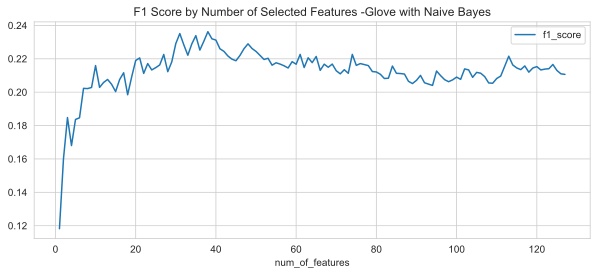

In [275]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [276]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
37,38,0.2362231,0.3020000
30,31,0.2351110,0.3020000
34,35,0.2338646,0.3000000
38,39,0.2319707,0.2980000
39,40,0.2311971,0.2980000


In [277]:
results_nb_glove = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test, scaler_min_max)

# Save benchmark output
# Save_Benchmark("Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "GloVe", results_nb_glove, False, False)
# df_benchmarks

#### Leave the Glove Feature result out for now since it clearly is problematic

## Combining Features

## Combine BOW and BAG of nGrams

In [278]:
def Get_Combined_Features(feat_1, feat_2):
    row_size = len(feat_1)
    col_size_1 = np.size(feat_1, axis=1)
    col_size_total = np.size(feat_1, axis=1) + np.size(feat_2, axis=1)
    X = np.zeros((row_size, col_size_total))
    
    for i in range(0, row_size):
        for j in range(0, col_size_1):
            X[i, j] = feat_1[i, j]

        for k in range(col_size_1, col_size_total):
            X[i, k] = feat_2[i, k - col_size_1]
    return X

#### Combine Features Arrays together

In [279]:
# Get Scaled BOW Features
x_bow_train_norm, x_bow_test_norn = Get_Scaled_Features(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, scaler_max_abs)

# Add Bag of nGrams
x_bong_train_norm, x_bong_test_norn = Get_Scaled_Features(results_bong_opt.x_train_sel, y_train, results_bong_opt.x_test_sel, y_test, scaler_max_abs)
x_train_bow_bong = Get_Combined_Features(x_bow_train_norm, x_bong_train_norm)
x_test_bow_bong = Get_Combined_Features(x_bow_test_norn, x_bong_test_norn)

# Add TF-IDF
# x_tfidf_train_norm, x_tfidf_test_norn = Get_Scaled_Features(results_tf_nb_opt.x_train_sel, y_train, results_tf_nb_opt.x_test_sel, y_test, scaler_max_abs)
# x_train_bow_bong = Get_Combined_Features(x_train_bow_bong, x_tfidf_train_norm)
# x_test_bow_bong = Get_Combined_Features(x_test_bow_bong, x_tfidf_test_norn)

# Add Word2Vec
# x_w2v_train_norm, x_w2v_test_norn = Get_Scaled_Features(results_nb_w2v.x_train_sel, y_train, results_nb_w2v.x_test_sel, y_test, scaler_max_abs)
# x_train_bow_bong = Get_Combined_Features(x_train_bow_bong, x_w2v_train_norm)
# x_test_bow_bong = Get_Combined_Features(x_test_bow_bong, x_w2v_test_norn)

In [280]:
print(x_train_bow_bong.shape)
print(x_test_bow_bong.shape)

(1500, 4421)
(500, 4421)


In [281]:
pd.DataFrame(x_test_bow_bong)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
1,0.1818182,0.3076923,0.0833333,0.2500000,0.4285714,0.0000000,0.5454545,0.3750000,0.3333333,0.0000000,0.4444444,0.1111111,0.0000000,0.3333333,0.2857143,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2,0.1818182,0.1538462,0.0000000,0.0000000,0.0000000,0.0769231,0.2727273,0.1250000,0.1111111,0.2500000,0.1111111,0.0000000,0.0000000,0.0000000,0.1428571,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
3,0.5454545,0.1538462,0.1666667,0.3333333,0.0000000,0.1538462,0.0909091,0.1250000,0.1111111,0.2500000,0.1111111,0.0000000,0.0000000,0.1666667,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
4,0.0000000,0.2307692,0.1666667,0.0833333,0.2857143,0.0000000,0.0000000,0.2500000,0.0000000,0.1250000,0.2222222,0.0000000,0.0000000,0.0000000,0.1428571,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.1818182,0.2307692,0.1666667,0.0833333,0.0000000,0.2307692,0.1818182,0.1250000,0.0000000,0.0000000,0.1111111,0.0000000,0.0000000,0.0000000,0.2857143,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
496,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
497,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
498,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [282]:
# model_bow_bong = GaussianNB() 
model_bow_bong = MultinomialNB()
results_nb_bow_bong = Build_Model(model_bow_bong, x_train_bow_bong, y_train, x_test_bow_bong, y_test)

In [283]:
Save_Benchmark("BOW and Bag of N-Grams Combined Baseline", "BOW_BONG", results_nb_bow_bong, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW and Bag of N-Grams Combined Baseline,BOW_BONG,0.9028311,0.8940000,0.8955480,0.8940000


In [284]:
print("Label" + results_nb_bow_bong.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        64
   coffee-ordering       1.00      1.00      1.00        58
      movie-finder       1.00      0.60      0.75        15
   movie-tickets-1       0.70      0.79      0.74        61
   movie-tickets-2       0.61      0.69      0.65        58
   movie-tickets-3       0.85      0.71      0.78        49
    pizza-ordering       1.00      1.00      1.00        56
  restaurant-table       1.00      1.00      1.00        63
restaurant-table-3       1.00      0.90      0.95        20
         uber-lyft       1.00      1.00      1.00        56

          accuracy                           0.89       500
         macro avg       0.92      0.87      0.89       500
      weighted avg       0.90      0.89      0.90       500



In [285]:
rows = []
for i in range(100, 4400, 100): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

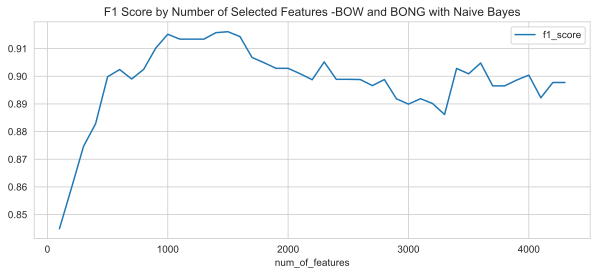

In [286]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [287]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

1450 1550 1


,num_of_features,f1_score,accuracy
14,1500,0.9161107,0.9160000
13,1400,0.9157713,0.9160000
9,1000,0.9151994,0.9160000
15,1600,0.9143424,0.9140000
10,1100,0.9134233,0.9140000


In [288]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

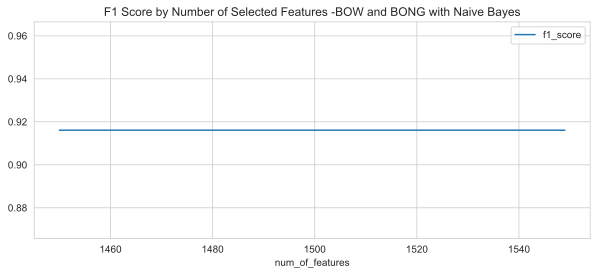

In [289]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [290]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
0,1450,0.9161107,0.9160000
63,1513,0.9161107,0.9160000
73,1523,0.9161107,0.9160000
72,1522,0.9161107,0.9160000
71,1521,0.9161107,0.9160000


In [291]:
#model_bow_bong = GaussianNB() # = MultinomialNB()
results_nb_bow_bong = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
Save_Benchmark("BOW + Bag of NGrams Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", "BOW_BONG", results_nb_bow_bong, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW and Bag of N-Grams Combined Baseline,BOW_BONG,0.9028311,0.8940000,0.8955480,0.8940000
1,BOW + Bag of NGrams Top: 1450 Features with Naive Bayes,BOW_BONG,0.9180580,0.9160000,0.9161107,0.9160000


## Try PCA Feature Extraction on the BOW Model 

In [292]:
from sklearn.decomposition import PCA

# Define PCA Selection Function
def Get_PCA_Features(i,  X_train_pca, y_train_pca, X_test_pca, y_test_pca):
    pca = PCA(n_components=i)
    fit = pca.fit(X_train_pca, y_train_pca)
    pca_train = fit.transform(X_train_pca)
    pca_test = fit.transform(X_test_pca)
    return pca_train, pca_test

In [293]:
# Loop through different no. of component values
model_nb_bow = GaussianNB()
rows = []
for i in range(5, 100, 1): # range(a, b, c) will count from a to b by intervals of c.
    x_train_pca_i, x_test_pca_i = Get_PCA_Features(i,  X_train_bow, y_train, X_test_bow, y_test)
    results_i = Build_Model(model_nb_bow, x_train_pca_i, y_train, x_test_pca_i, y_test)
    rows.append([i, results_i.f1_score, results_i.accuracy])
acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

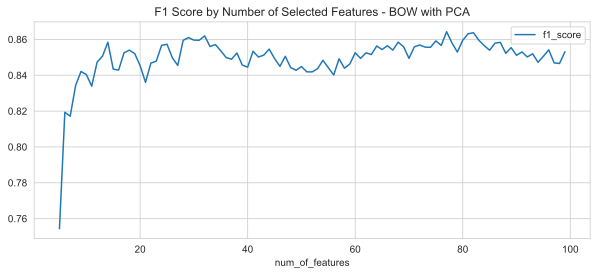

In [294]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with PCA", figsize=(10, 4))

In [295]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

77


,num_of_features,f1_score,accuracy
72,77,0.8643053,0.8700000
77,82,0.8637362,0.8700000
76,81,0.8631540,0.8700000
27,32,0.8619772,0.8680000
24,29,0.8610434,0.8660000


In [296]:
x_train_pca, x_test_pca = Get_PCA_Features(Opt_no_of_feat,  X_train_bow, y_train, X_test_bow, y_test)
results_bow_pca = Build_Model(model_nb_bow, x_train_pca, y_train, x_test_pca, y_test)
Save_Benchmark("BOW With Top: " + str(Opt_no_of_feat) + "  PCA Components Seleted", "BOW_PCA", results_bow_pca, True, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW With Top: 77 PCA Components Seleted,BOW_PCA,0.8596310,0.8580000,0.8519978,0.8580000


In [297]:
pd.DataFrame(x_train_pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,4.8042274,-0.5349770,-3.0935990,3.5206852,0.8595648,2.5708999,1.4468828,0.8308296,-1.8376497,-0.1516106,2.4575367,1.5901858,1.6688270,0.7768541,0.9776745,...,-0.4701112,0.3251439,0.8454242,-0.3152505,-0.6326123,-0.8272424,0.0374409,-0.2866289,0.1323353,0.5130042,-0.1545874,0.0164289,0.2214224,0.1218408,0.1191521
1,3.8741890,-0.4806744,-0.7191316,2.8247115,0.3060222,-0.6313722,0.2795933,-0.9118701,-3.1195159,-2.2919513,-0.3729334,0.7510973,1.5652284,0.3431141,-2.2053845,...,0.5618543,0.0449610,0.4881141,0.8254106,0.7838670,-0.0066646,0.2463180,0.4024917,-1.2223381,-0.2080745,0.6834637,-0.2910653,0.3511866,-0.7390779,-0.0382416
2,-3.8383749,-0.8163666,0.0777180,0.2415571,0.1257935,-0.1742466,0.0130064,0.0416642,0.0977520,0.0180676,-0.0045256,-0.0067739,-0.0683646,-0.0261642,0.0035003,...,-0.0052113,0.0004783,-0.0042483,0.0018459,0.0051154,-0.0193499,-0.0098798,0.0038965,-0.0012368,0.0031749,-0.0163969,0.0003761,0.0059780,0.0102056,-0.0010697
3,3.6905587,0.3434076,-4.7039332,-3.3715504,-0.8026080,-1.5097845,-2.4251959,1.2610144,-0.1053212,0.1916935,-1.0373666,-1.5744863,0.5282132,-0.9826389,-0.8930665,...,2.1719080,1.3519620,0.6702712,-1.2378857,0.0754959,-0.1642209,-1.1235043,-0.1666327,-0.2426123,0.1062631,0.1180969,0.3258684,0.3274728,-0.0903407,-2.0636619
4,5.3005598,-2.0383961,5.0195881,-2.1703291,-1.9207447,-0.5637204,-1.0255240,0.5016916,1.3880246,0.3378129,1.0794364,0.4467219,0.8372120,-1.5556996,0.6316829,...,0.5170366,-0.1056774,-1.2274498,-0.1723894,-1.6431497,0.2669157,0.5974148,0.9273381,-0.3912404,-0.0709778,-1.6570625,-0.0854389,0.5529825,0.2486267,0.5649418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,4.3476111,1.9975030,-4.4235647,2.2181234,-0.1270302,0.0538555,-3.6854347,1.2091184,1.4914819,1.3324516,-1.4431645,1.4989957,0.8197164,-2.9374230,1.2190667,...,-0.8206905,-0.4977244,-0.6751826,0.2268062,0.5612502,-0.5454750,-0.5267373,0.0683390,0.3926021,0.4978850,0.9964330,0.0166125,-0.2252399,-0.3412961,0.4385370
1496,-3.8394152,-0.8170046,0.0778021,0.2418832,0.1260047,-0.1746005,0.0130401,0.0418007,0.0981052,0.0181500,-0.0045478,-0.0068102,-0.0687604,-0.0263185,0.0035239,...,-0.0055861,-0.0006794,-0.0049204,0.0024260,0.0075225,-0.0199878,-0.0079163,0.0038847,0.0014612,0.0048314,-0.0159826,-0.0024101,-0.0003375,0.0052216,0.0033745
1497,-3.8383749,-0.8163666,0.0777180,0.2415571,0.1257935,-0.1742466,0.0130064,0.0416642,0.0977520,0.0180676,-0.0045256,-0.0067739,-0.0683646,-0.0261642,0.0035003,...,-0.0052113,0.0004783,-0.0042483,0.0018459,0.0051154,-0.0193499,-0.0098798,0.0038965,-0.0012368,0.0031749,-0.0163969,0.0003761,0.0059780,0.0102056,-0.0010697
1498,5.7027320,-1.6377543,2.6618644,1.7445583,-1.7611757,0.9642014,0.6451358,3.4320513,0.0904375,-0.6699205,-1.5026215,-1.5168486,-0.8865752,-0.0154152,0.0462468,...,-0.2202882,0.1038622,0.5042112,0.5788665,-0.3957453,-0.2006484,0.5918272,0.6986919,-0.5668187,0.1860371,0.4501243,0.2094865,-0.2782739,-0.6013006,-0.1625579


## Feature Engineering, Extraction and Selection Final Results

In [298]:
# Show All benchmarks
df_benchmarks_all

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.9306527,0.9240000,0.9253405,0.9240000
1,BOW Naive Bayes Optimal Features Selected: 849,BOW,0.9478845,0.9440000,0.9449159,0.9440000
2,Bag of N-Gram Naive Bayes baseline,BONG,0.3878078,0.4260000,0.3815457,0.4260000
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 3572,BONG,0.3832918,0.4300000,0.3812146,0.4300000
4,TF-IDF Naive Bayes Baseline,TF-IDF,0.8466997,0.8160000,0.8026432,0.8160000
5,TF-IDF Naive Bayes Optimal Features Selected: 334,TF-IDF,0.9008577,0.8820000,0.8766820,0.8820000
6,Word2Vec Naive Bayes Baseline,Word2Vec,0.9134222,0.9080000,0.9095227,0.9080000
7,Word2Vec Naive Bayes Optimal Features Selected: 88,Word2Vec,0.9164375,0.9120000,0.9133787,0.9120000
8,Word2Vec Fastext Naive Bayes Baseline,Word2Vec_FT,0.8796808,0.8680000,0.8661048,0.8680000
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 86,Word2Vec_FT,0.8810174,0.8720000,0.8704664,0.8720000


#### Best results were produced from the BOW Features with optimal Features selected using a Naive Bayes Multinomial Model

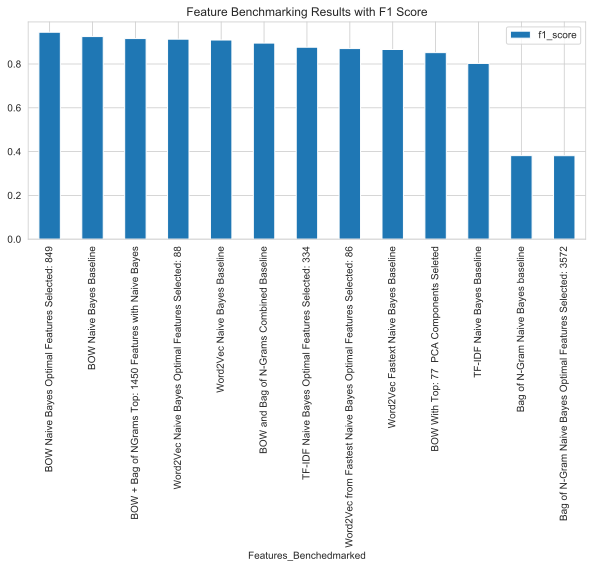

In [299]:
df_benchmarks_all.sort_values(by='f1_score', ascending=False).plot(x="Features_Benchedmarked", y="f1_score", kind='bar', title="Feature Benchmarking Results with F1 Score", figsize=(10, 4))

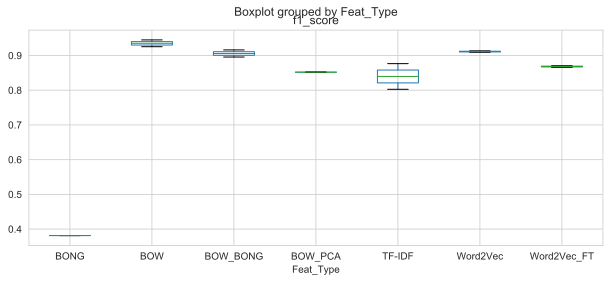

In [300]:
df_benchmarks_all.boxplot(column=['f1_score'], by='Feat_Type', figsize=(10, 4))

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features
#### This gives us a visual on where the model is failing

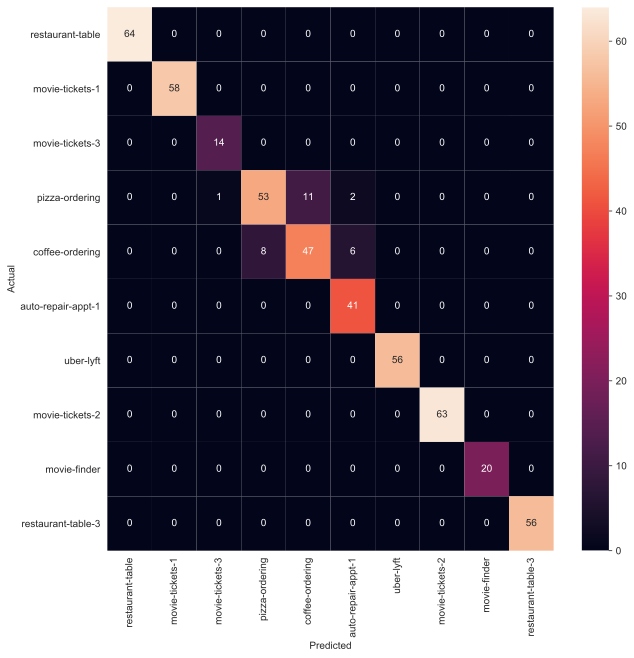

In [301]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(rm_chi_opt_bow.cm, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [302]:
scaler_ma = MaxAbsScaler()
x_bow_train_norm, x_bow_test_norn = SelectAndScaleFeatures_0_1(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, scaler_ma)
x_bong_train_norm, x_bong_test_norn = SelectAndScaleFeatures_0_1(results_bong_opt.x_train_sel, y_train, results_bong_opt.x_test_sel, y_test, scaler_ma)
x_tfidf_train_norm, x_tfidf_test_norn = SelectAndScaleFeatures_0_1(results_tf_nb_opt.x_train_sel, y_train, results_tf_nb_opt.x_test_sel, y_test, scaler_ma)
x_w2v_train_norm, x_w2v_test_norn = SelectAndScaleFeatures_0_1(results_nb_w2v.x_train_sel, y_train, results_nb_w2v.x_test_sel, y_test, scaler_ma)

NameError: name 'SelectAndScaleFeatures_0_1' is not defined

In [303]:
df_x_opt = pd.DataFrame(x_w2v_train_norm)
# results_nb_ft.x_test_sel, results_nb_glove.x_test_sel)
df_x_opt

NameError: name 'x_w2v_train_norm' is not defined

## Additional Research

### Custom Trained RNN Classifier Model using FLAIR with GloVe Embeddings

In [304]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
#from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask

corpus_df.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [305]:
# Uncomment this section to re-write data files
# c_df = corpus_df.filter(['selfdialog_norm','Instruction_id'], axis=1)
# c_df.columns = ['text', 'label_instruction_id']

# train, dev, test = np.split(c_df.sample(frac=1), [int(.6*len(c_df)), int(.8*len(c_df))])
# train.to_csv(r'.\flairdata\train.txt')
# dev.to_csv(r'.\flairdata\dev.txt')
# test.to_csv(r'.\flairdata\test.txt')

In [306]:
# this is the folder in which train, test and dev files reside
data_folder = './flairdata'

# column format indicating which columns hold the text and label(s)
column_name_map = {1: "text", 2: "label_instruction_id"}

# load corpus containing training, test and dev data and if CSV has a header, you can skip it
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter=',', 
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'flairdata'

In [307]:
# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'),

                   # comment in flair embeddings for state-of-the-art results
                   # FlairEmbeddings('news-forward'),
                   # FlairEmbeddings('news-backward'),
                   ]

NameError: name 'corpus' is not defined

In [308]:
print(corpus)

NameError: name 'corpus' is not defined

In [309]:
# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

NameError: name 'word_embeddings' is not defined

In [310]:
# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/ag_news',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=6)

NameError: name 'label_dict' is not defined

In [311]:
from flair.embeddings import Sentence

# create example sentence
sentence = Sentence('France is the current world cup winner.')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

NameError: name 'classifier' is not defined